## Week 5 HW: ARIMA vs Prophet
### Jingwen Li

In [151]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller, kpss
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.linear_model import LinearRegression
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteScaledError
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

## Part 1. 10 pts - Exploratory Data Analysis

### a. Merge the data sets together, should have 735 rows of data  


In [2]:
co2 = pd.read_csv('hw5_data_co2.csv', index_col=0, parse_dates=True)
temp = pd.read_csv('hw5_data_temp.csv', index_col=0, parse_dates=True)

In [3]:
co2

,co2
ds,
1958-03-15,315.700
1958-04-15,317.450
1958-05-15,317.510
1958-06-15,316.685
1958-07-15,315.860
...,...
2019-01-15,410.920
2019-02-15,411.660
2019-03-15,412.000


In [4]:
temp

,temp
ds,
1880-01-01,56.40
1880-02-01,56.82
1880-03-01,56.74
1880-04-01,56.55
1880-05-01,56.85
...,...
2019-02-01,58.37
2019-03-01,58.59
2019-04-01,58.50


In [5]:
y = pd.merge_asof(co2, temp, on='ds', direction='nearest').set_index('ds')
y

,co2,temp
ds,,
1958-03-15,315.700,57.38
1958-04-15,317.450,57.29
1958-05-15,317.510,57.32
1958-06-15,316.685,57.02
1958-07-15,315.860,57.27
...,...,...
2019-01-15,410.920,58.29
2019-02-15,411.660,58.37
2019-03-15,412.000,58.59


### b. Complete a quantitative and qualitative data exploration. Include a verbal summary of your EDA.

    Numerical

In [6]:
y.describe()

,co2,temp
count,735.000000,735.000000
mean,354.210673,57.603293
std,27.922811,0.397159
min,313.200000,56.730000
25%,328.785000,57.280000
50%,351.340000,57.590000
75%,376.515000,57.915000
max,414.830000,58.840000


In [7]:
y.isna().sum()

co2     0
temp    0
dtype: int64

    Visual

<AxesSubplot: xlabel='ds'>

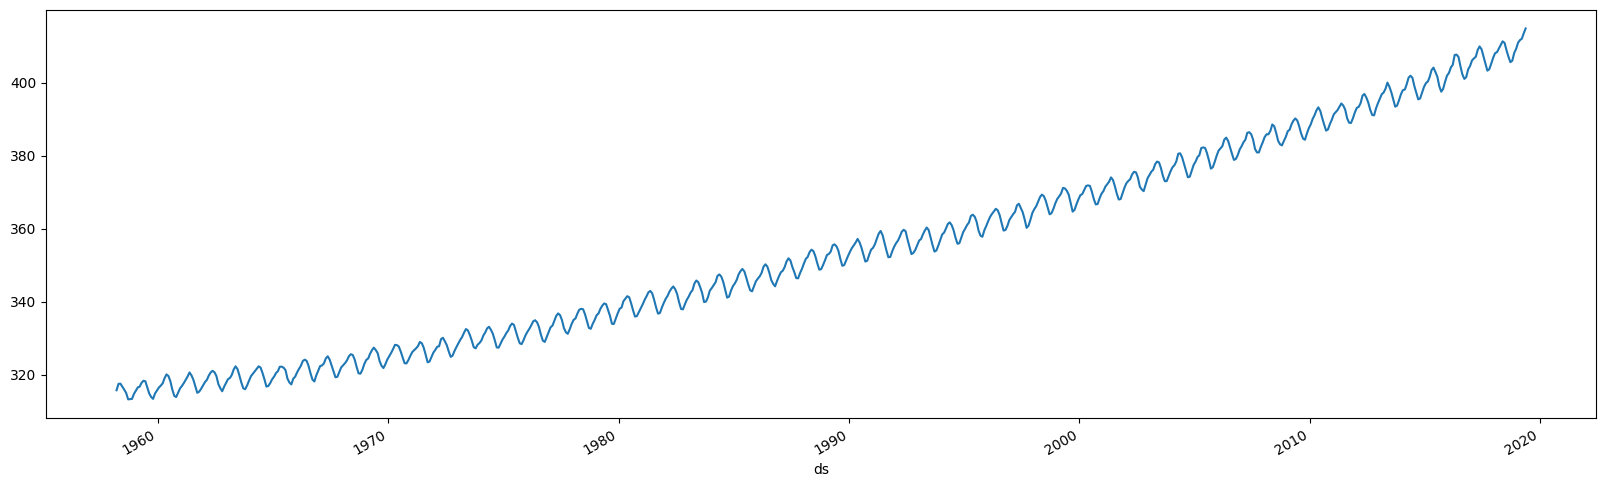

In [8]:
y['co2'].plot(figsize=(20, 6))

<AxesSubplot: xlabel='ds'>

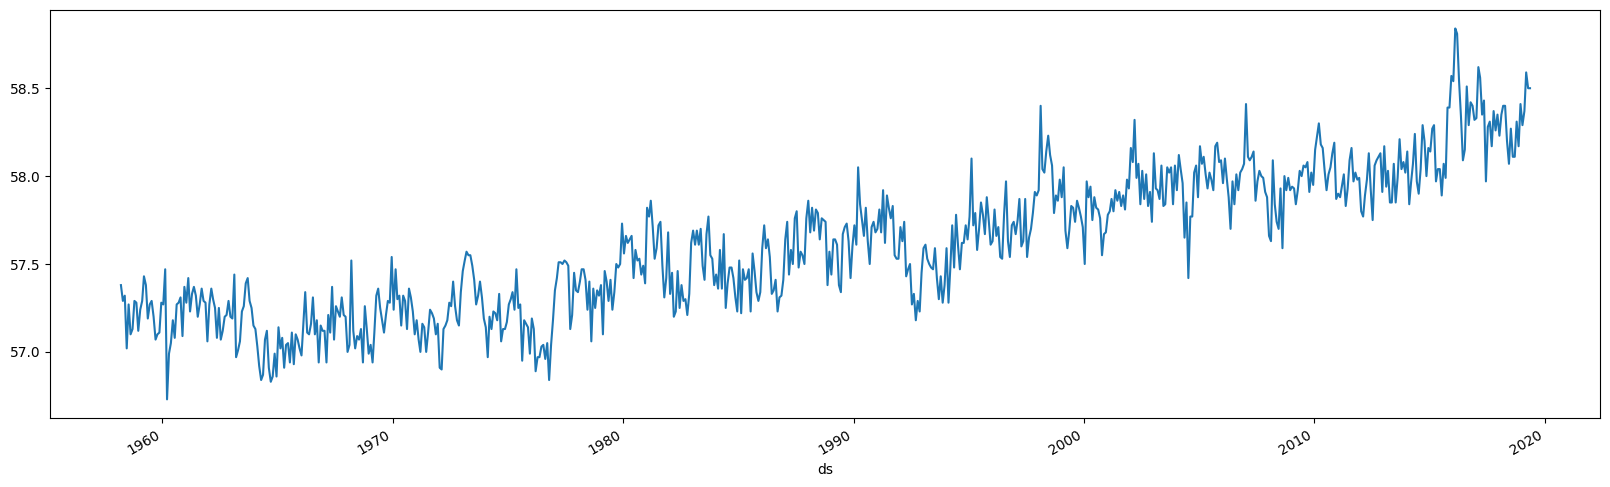

In [9]:
y['temp'].plot(figsize=(20, 6))

### Summary:

There are 735 data points in each column, and the mean value of the "co2" column is 354.21 ppm with a standard deviation of 27.92 ppm. The mean value of the "temp" column is 57.60 degrees Celsius with a standard deviation of 0.40 degrees Celsius.

The minimum value of the "co2" column is 313.20 ppm, and the maximum value is 414.83 ppm. The minimum value of the "temp" column is 56.73 degrees Celsius, and the maximum value is 58.84 degrees Celsius. The median (50th percentile) value of the "co2" column is 351.34 ppm, and the median value of the "temp" column is 57.59 degrees Celsius. The 25th percentile of the "co2" column is 328.79 ppm, and the 75th percentile is 376.52 ppm. The 25th percentile of the "temp" column is 57.28 degrees Celsius, and the 75th percentile is 57.92 degrees Celsius.

From the plots, we can see a clear upward trend and seanal pattern for both datasets, and there are more noises in the temprature data.

## Part 2. 35 pts – ARIMA with external regressors

### a. Split Temp into train test. Determine the transformation, seasonal differencing & non seasonal differencing orders if required. Include the following: plot of differenced data, ADF results, kpss results, ACF/PACF plots.

In [28]:
y_train, y_test = temporal_train_test_split(y)

In [11]:
y_train.shape

(551,)

In [12]:
y_test.shape

(184,)

In [57]:
co2_train = y_train['co2']
co2_test = y_test['co2']

In [32]:
temp_train = y_train['temp']
temp_test = y_test['temp']

    seasonal differencing

<AxesSubplot: xlabel='ds'>

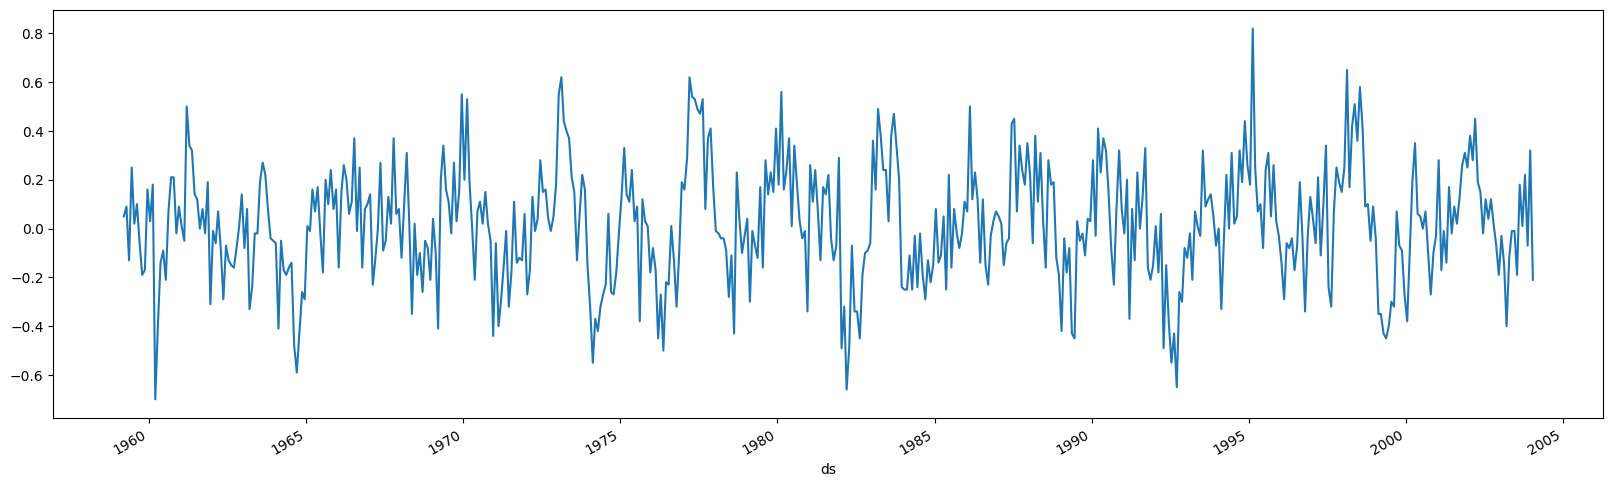

In [33]:
trans_sdiff_data = (temp_train-temp_train.shift(12)).iloc[1:]
trans_sdiff_data.plot(figsize=(20, 6))

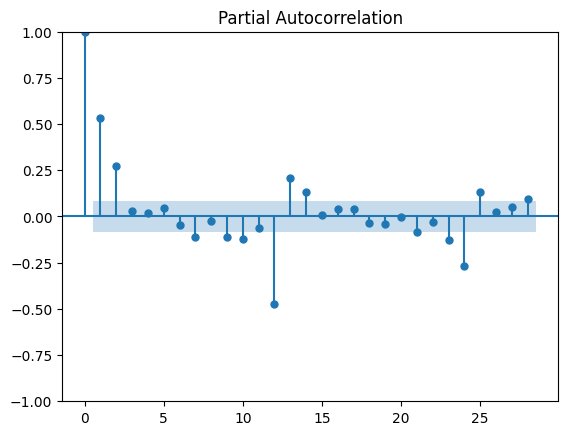

In [34]:
plot_pacf(trans_sdiff_data.dropna())
plt.show()

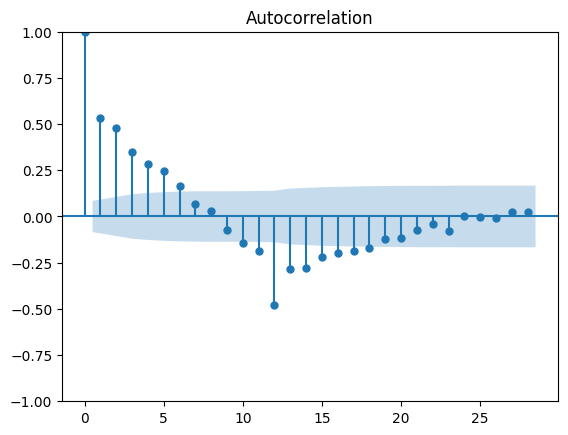

In [35]:
plot_acf(trans_sdiff_data.dropna())
plt.show()

In [36]:
def adf_kpss_test(data):
    # ADF test
    result_adf = adfuller(data)
    print('ADF Test:')
    print(f'ADF Statistic: {round(result_adf[0],3)}')
    print(f'p-value: {round(result_adf[1],3)}')
    print(f'Critical Values: {result_adf[4]}')
    #print whether the data is stationary or not at 1% significance level
    if abs(result_adf[0]) > abs(result_adf[4]['1%']) and result_adf[1] < 0.05:
        print('We can reject the null hypothesis at 1% significance level that the data is NOT stationary. The data is likely stationary')
    else:
        print('We cannot reject the null hypothesis at 1% significance level that the data is NOT stationary. The data is likely NOT stationary')
        
    # KPSS test
    result_kpss = kpss(data, nlags='auto')
    print('\nKPSS Test:')
    print(f'KPSS Statistic: {round(result_kpss[0],3)}')
    print(f'p-value: {round(result_kpss[1],3)}')
    print(f'Critical Values: {result_kpss[3]}')
    #print whether the data is stationary or not at 1% significance level
    if abs(result_kpss[0]) > abs(result_kpss[3]['1%']) and result_kpss[1] < 0.05:
        print('We can reject the null hypothesis at 1% significance level that the data is stationary. The data is likely NOT stationary')
    else:
        print('We cannot reject the null hypothesis at 1% significance level that the data is stationary. The data is likely stationary')
        
    if result_adf[0] > result_adf[4]['1%'] and result_kpss[0] > result_kpss[3]['1%']:
        print('The ADF and KPSS tests are giving conflicting results.')


In [109]:
adf_kpss_test(trans_sdiff_data.dropna())

ADF Test:
ADF Statistic: -7.25
p-value: 0.0
Critical Values: {'1%': -3.4428672600488066, '5%': -2.8670609714890403, '10%': -2.5697104770975057}
We can reject the null hypothesis at 1% significance level that the data is NOT stationary. The data is likely stationary

KPSS Test:
KPSS Statistic: 0.045
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
We cannot reject the null hypothesis at 1% significance level that the data is stationary. The data is likely stationary


### b. Fit a SARIMA or ARIMA model based on your examinations. Examine the residuals. Include the following: plot, histogram, ACF, Ljung Box results. Check if auto arima gives you a different order. If this is a better model, examine the residuals of this model.

In [97]:
model = SARIMAX(temp_train, order=(12, 0, 24), seasonal_order=(0,1,0,12))
model_fit = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63823D-01    |proj g|=  4.79256D+00

At iterate    5    f= -3.49302D-01    |proj g|=  3.37838D-01

At iterate   10    f= -4.87870D-01    |proj g|=  7.54539D-02

At iterate   15    f= -5.19345D-01    |proj g|=  2.72828D-01

At iterate   20    f= -5.23655D-01    |proj g|=  1.07050D-01

At iterate   25    f= -5.26562D-01    |proj g|=  3.51401D-02

At iterate   30    f= -5.28349D-01    |proj g|=  2.57933D-02

At iterate   35    f= -5.30577D-01    |proj g|=  1.31072D-01

At iterate   40    f= -5.32859D-01    |proj g|=  4.16256D-02

At iterate   45    f= -5.33731D-01    |proj g|=  4.83478D-02

At iterate   50    f= -5.34423D-01    |proj g|=  2.62629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [98]:
print(model_fit.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                  temp   No. Observations:                  551
Model:             SARIMAX(12, 0, 24)x(0, 1, [], 12)   Log Likelihood                 294.467
Date:                               Fri, 05 May 2023   AIC                           -514.934
Time:                                       20:16:19   BIC                           -356.214
Sample:                                            0   HQIC                          -452.854
                                               - 551                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0754      0.262      0.288      0.773      -0.438       0.588
ar.L2      

In [99]:
# Return AICc
print("AICc for order " + str(model.order) + str(model.seasonal_order) +": " +str(model_fit.aicc))

AICc for order (12, 0, 24)(0, 1, 0, 12): -509.32088183228404


In [100]:
residuals = model_fit.resid[13:]

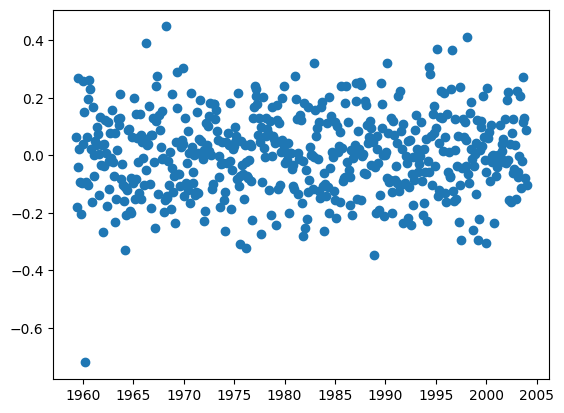

In [101]:
plt.scatter(residuals.index, residuals)

<AxesSubplot: ylabel='Frequency'>

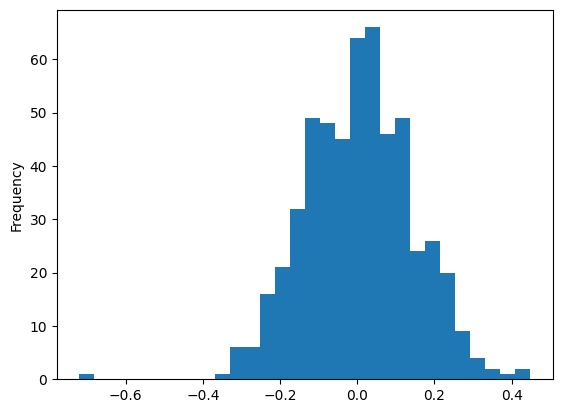

In [103]:
residuals.plot(kind='hist', bins=30)

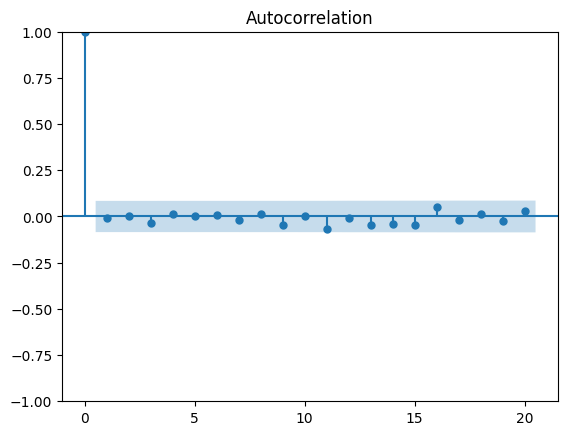

In [104]:
plot_acf(residuals, lags=20)
plt.show()

In [105]:
lb_test = acorr_ljungbox(residuals, lags=20)
lb_test

,lb_stat,lb_pvalue
1,0.060637,0.805492
2,0.060673,0.970119
3,0.648863,0.885161
4,0.719001,0.948965
5,0.724854,0.981577
6,0.775701,0.992709
7,0.972963,0.995253
8,1.084499,0.997656
9,2.386570,0.983780
10,2.387052,0.992421


Comment: From the plots, histogram we can conclude that the residuals are independently distributed with no significant autocorrelation, which suggests that the SARIMA model is a good fit for the time series data.

    Using AutoArima

In [106]:
model_auto = auto_arima(temp_train, seasonal=True, m=12)
model_auto_fit = model_auto.fit(temp_train)

In [107]:
print(model_auto_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  551
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 303.707
Date:                Fri, 05 May 2023   AIC                           -597.414
Time:                        20:17:46   BIC                           -575.865
Sample:                             0   HQIC                          -588.993
                                - 551                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      2.353      0.019    7.92e-05       0.001
ar.L1          0.4027      0.045      9.048      0.000       0.315       0.490
ar.L2          0.2499      0.048      5.256      0.0

### Comment: 

Based on these criteria, Model 2 has a lower AIC value and a higher log-likelihood value, indicating that it is a better model.

In [127]:
residuals = model_auto_fit.resid()[13:]

In [128]:
residuals

1959-04-15    0.031846
1959-05-15   -0.175296
1959-06-15    0.002869
1959-07-15    0.037499
1959-08-15   -0.082932
                ...   
2003-09-15    0.063643
2003-10-15    0.050897
2003-11-15   -0.165669
2003-12-15    0.135830
2004-01-15   -0.044787
Length: 538, dtype: float64

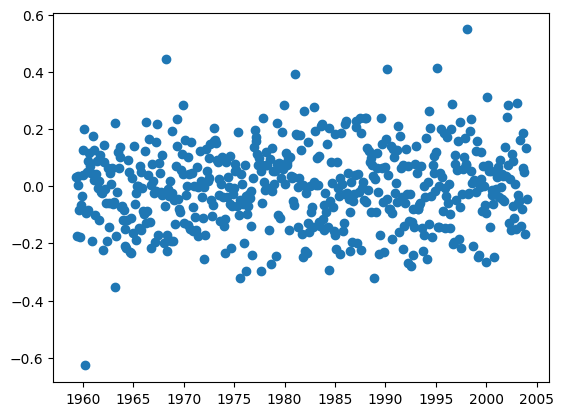

In [129]:
plt.scatter(residuals.index, residuals)

<AxesSubplot: ylabel='Frequency'>

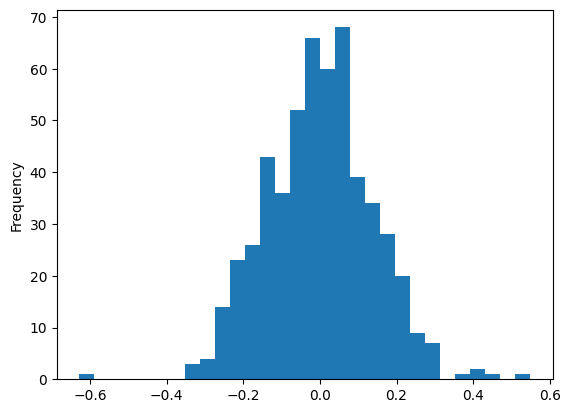

In [130]:
residuals.plot(kind='hist', bins=30)

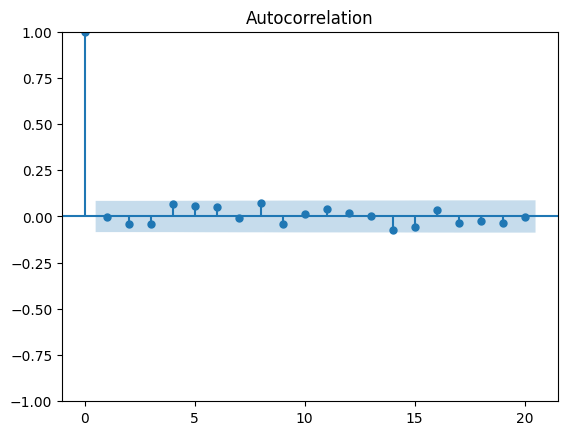

In [131]:
plot_acf(residuals, lags=20)
plt.show()

In [132]:
lb_test = acorr_ljungbox(residuals, lags=20)
lb_test

,lb_stat,lb_pvalue
1,0.012554,0.910789
2,0.805836,0.668367
3,1.801812,0.614541
4,4.396449,0.355003
5,6.202332,0.287026
6,7.513870,0.275924
7,7.547987,0.374132
8,10.311322,0.243851
9,11.311108,0.254985
10,11.433211,0.324777


Comment: From the plots, histogram we can conclude that the residuals are independently distributed with no significant autocorrelation, which suggests that the SARIMA model is a good fit for the time series data.

### c. Using your best model, predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [113]:
fh = list(range(1, 1+len(temp_test)))
temp_auto_pred = model_auto_fit.predict(n_periods=len(fh))
temp_pred = model_fit.forecast(steps = len(temp_test))

In [115]:
# Calculate MAE and MSE
MAE = mean_absolute_error(temp_test, temp_pred)
MSE = mean_squared_error(temp_test, temp_pred)

# Calculate MAPE and sMAPE
MAPE = MeanAbsolutePercentageError(symmetric=False)(temp_test, temp_pred)
SMAPE = MeanAbsolutePercentageError(symmetric=True)(temp_test, temp_pred)

MASE = MeanAbsoluteScaledError()(temp_test, temp_pred, y_train=temp_train)

# Print the results
print("MAE:", MAE)
print("MSE:", MSE)
print("MAPE:", MAPE)
print("sMAPE:", SMAPE)
print("MASE:", MASE)

MAE: 0.1724546317857681
MSE: 0.05086730757808922
MAPE: 0.002965215660328378
sMAPE: 0.0029680976008197315
MASE: 1.3511402775238237


### d. Refit your best model by adding co2 as an external regressor. Examine the residuals of this model.

In [140]:
model = SARIMAX(temp_train, co2_train, order=(2, 1, 1))
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.83918D-01    |proj g|=  2.16281D+00

At iterate    5    f= -4.99712D-01    |proj g|=  1.82604D+00

At iterate   10    f= -5.25912D-01    |proj g|=  1.33695D-01

At iterate   15    f= -5.32158D-01    |proj g|=  3.27089D-01

At iterate   20    f= -5.48431D-01    |proj g|=  1.69623D-02

At iterate   25    f= -5.55087D-01    |proj g|=  6.77732D-02

At iterate   30    f= -5.56264D-01    |proj g|=  3.22477D-02

At iterate   35    f= -5.56346D-01    |proj g|=  6.93043D-02

At iterate   40    f= -5.56639D-01    |proj g|=  1.65002D-01

At iterate   45    f= -5.56776D-01    |proj g|=  2.32639D-02

At iterate   50    f= -5.56819D-01    |proj g|=  4.45765D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


In [141]:
# Return AICc
print("AICc for order " + str(model.order) + str(model.seasonal_order) +": " +str(model_fit.aicc))

AICc for order (2, 1, 1)(0, 0, 0, 0): -603.5042368319588


In [142]:
residuals = model_fit.resid[13:]

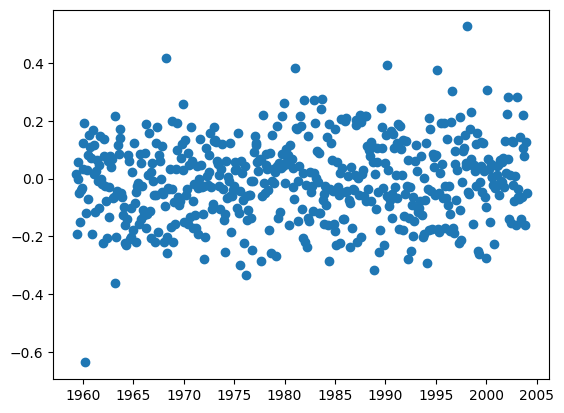

In [143]:
plt.scatter(residuals.index, residuals)

<AxesSubplot: ylabel='Frequency'>

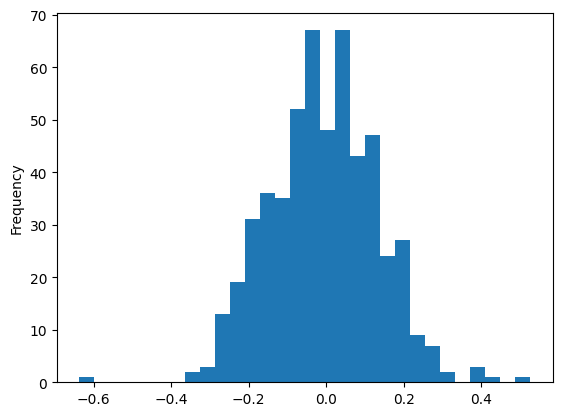

In [144]:
residuals.plot(kind='hist', bins=30)

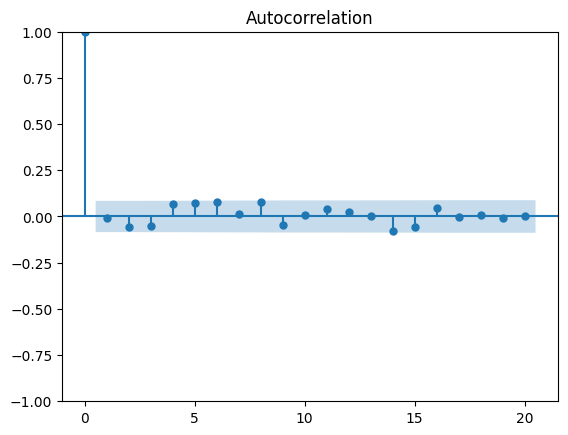

In [145]:
plot_acf(residuals, lags=20)
plt.show()

In [146]:
lb_test = acorr_ljungbox(residuals, lags=20)
lb_test

,lb_stat,lb_pvalue
1,0.053458,0.817152
2,1.789936,0.408621
3,3.384600,0.336040
4,5.953105,0.202678
5,8.932341,0.111793
6,12.152861,0.058644
7,12.258830,0.092362
8,15.551316,0.049271
9,16.769661,0.052448
10,16.804201,0.078810


Comment: From the plots, histogram we can conclude that the residuals are independently distributed with no significant autocorrelation, which suggests that the model is doing well

### e. Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [147]:
forecast = model_fit.forecast(steps=len(temp_test), exog=co2_test)

In [149]:
# Calculate MAE and MSE
MAE = mean_absolute_error(temp_test, forecast)
MSE = mean_squared_error(temp_test, forecast)

# Calculate MAPE and sMAPE
MAPE = MeanAbsolutePercentageError(symmetric=False)(temp_test, forecast)
SMAPE = MeanAbsolutePercentageError(symmetric=True)(temp_test, forecast)

MASE = MeanAbsoluteScaledError()(temp_test, forecast, y_train=temp_train)

# Print the results
print("MAE:", MAE)
print("MSE:", MSE)
print("MAPE:", MAPE)
print("sMAPE:", SMAPE)
print("MASE:", MASE)

MAE: 0.14542174728389237
MSE: 0.035239780472337834
MAPE: 0.002505375206349828
sMAPE: 0.002503188646619127
MASE: 1.1393441738766494


### Comment:

Comparing the model performance metrics, we can see that the model with exogenous variables has lower MAE, MSE, MAPE, sMAPE, and MASE values. This suggests that the model with exogenous variables is performing better than the model without exogenous variables.

## Part 3. 35 pts – Prophet with additional regressors

### a. Using the same train test split as part 2, fit a prophet model to your NON-differenced training set. Examine the residuals. Using the predicted values and y train, calculate the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [156]:
co2 = pd.read_csv('hw5_data_co2.csv', index_col=0, parse_dates=True)
temp = pd.read_csv('hw5_data_temp.csv', index_col=0, parse_dates=True)

In [157]:
df = pd.merge_asof(co2, temp, on='ds', direction='nearest')

In [158]:
df['y'] = df['temp']

In [168]:
train = df.iloc[:551]
test = df.iloc[551:]

In [169]:
train.shape

(551, 4)

In [170]:
test.shape

(184, 4)

In [171]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2972.98    0.00237231        6058.3       0.469       0.469      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2984.53    0.00234323       3163.23           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2993.81    0.00043079        1217.5           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2997.64    0.00447102       1628.65           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2999.15   0.000107841       573.451      0.9289      0.9289      551   
    Iter      log prob        ||dx||      ||grad||       alpha    

     ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1648       3004.08   8.76024e-07       82.9502   1.033e-08       0.001     1926  LS failed, Hessian reset 
    1699       3004.08    7.2385e-06       72.6998           1           1     1986   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1709       3004.09   4.19173e-06       167.945   3.537e-08       0.001     2041  LS failed, Hessian reset 
    1799        3004.1   1.85254e-05       93.8959           1           1     2151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1899       3004.17   3.32635e-05       266.217      0.2605           1     2263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1913       3004.17   1.46259e-06       59.2258   1.281e-08       0.001     2327  LS failed, Hessian reset 
    1960       3004.17   4.60337e-07       35.1897   8.643e-09 

In [172]:
future_data = model.make_future_dataframe(periods=len(test), freq='m')

### b. Adjust seasonality, changepoint priors or other methods to see if you can create a better fit model. Examine the residuals. Using the predicted values and y train, calculate the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

### c. Using your best prophet model, include co2 as an external regressor. Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

### d. Give a summary of your modeling in prophet. What improved the model, what made the fit worse. Give your reasonings why this would happen given the patterns in the data.

## Part 4. 10 pts – conclusion

### a. Which was the best model according to your error metrics?

### d. If you had this data for 100 locations (different pairs of time series), how would you approach modeling this data?